
# Opis projektu
___
**Celem projektu była analiza ofert materacy dostępnych w sklepach internetowych oraz zbadanie opinii klientów na temat tych produktów. W projekcie wykorzystano dane z dwóch popularnych sklepów: IKEA oraz Magnat Meble. Cały proces obejmował web scraping danych ze sklepów internetowych, przygotowanie i czyszczenie zebranych danych, eksploracyjną analizę danych (EDA), analizę porównawczą ofert oraz analizę sentymentu opinii klientów.**


**Aby zapewnić spójność,  dane zostały zorganizowane w następujacej strukturze katalogów:**
- **Raw Data**: `data/raw/`
  - `ikea.csv` - surowe dane zebrane z IKEA
  - `magnat.csv` - surowe dane zebrane z Magnat
  - `reviews.csv` - surowy zestaw danych do analizy sentymentu
- **Processed Data**: `data/processed/`
  - `ikea_clean.csv` - oczyszczone i przetworzone dane z IKEA.
  - `magnat_clean.csv` - oczyszczone i przetworzone dane z Magnat


In [ ]:
from webdriver_manager.chrome import ChromeDriverManager
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import plotly.express as px

import contractions
from string import punctuation
import re
import spacy
import nltk
from nltk.corpus import stopwords
from googletrans import Translator
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

import locale
locale.setlocale(locale.LC_TIME, "pl_PL.UTF-8")

# Sekcja 1: Web scraping i eksploracyjna analiza danych
---
**Pierwszym etapem było zgromadzenie danych poprzez web scraping, który objął informacje o nazwach produktów, cenach, dostępności, rodzajach, rozmiarach oraz opiniach klientów. Po odpowiednim przygotowaniu danych przeprowadzono eksploracyjną analizę, która pozwoliła na wstępną charakterystykę ofert obu sklepów.**

## Ikea mattresses 

### Web Scraping

In [ ]:
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service)
driver.get("https://www.ikea.com/pl/pl/cat/materace-bm002")

time.sleep(10)

accept_button = driver.find_element(by=By.ID, value='onetrust-accept-btn-handler')
accept_button.click()

In [ ]:
while True:
    try:
        show_more_button = driver.find_element(By.XPATH, "//a[contains(@class, 'plp-btn') and contains(@class, 'plp-btn--small')]")
        show_more_button.click()
        time.sleep(5)  
        
    except NoSuchElementException:
        break

In [ ]:
products = driver.find_elements(By.CLASS_NAME, 'plp-fragment-wrapper')

ikea_products = []

for product in products:
    try:
        name = product.find_element(By.CLASS_NAME, 'plp-price-module__description').text
        price = product.find_element(By.CLASS_NAME, 'plp-price__integer').text

        try:
            review_element = product.find_element(By.CSS_SELECTOR, 'span[aria-label]')
            review = review_element.get_attribute('aria-label')
        except:
            review = np.nan

        availability = product.find_element(By.CLASS_NAME, 'plp-status__label').text  
        product_link = product.find_element(By.CSS_SELECTOR, 'a.plp-product__image-link').get_attribute('href')

        ikea_products.append({
            'name': name,
            'price': price,
            'review': review,
            'availability': availability,
            'link': product_link  
        })
    
    except Exception as e:
        print(f"Error extracting data for a product: {e}")

driver.quit()

In [ ]:
ikea = pd.DataFrame(ikea_products)
# ikea.to_csv('data/raw/ikea.csv', index=False)

### Data Cleaning

In [ ]:
# ikea = pd.read_csv('data/raw/ikea.csv')
ikea.head(5)

,name,price,review,availability,link
0,"Materac, sprężyny kieszeniowe, 140x200 cm",999,Recenzja: 4.7 z 5 gwiazdki. Łączna liczba rece...,Dostępne z dostawą,https://www.ikea.com/pl/pl/p/valevag-materac-s...
1,"Materac, sprężyny kieszeniowe, 160x200 cm",999,Recenzja: 4.8 z 5 gwiazdki. Łączna liczba rece...,Dostępne z dostawą,https://www.ikea.com/pl/pl/p/vesteroey-materac...
2,"Materac, sprężyny kieszeniowe, 160x200 cm",2 299,Recenzja: 4.7 z 5 gwiazdki. Łączna liczba rece...,Dostępne z dostawą,https://www.ikea.com/pl/pl/p/vagstranda-matera...
3,"Materac sprężynowy, 140x200 cm",699,Recenzja: 4.7 z 5 gwiazdki. Łączna liczba rece...,Dostępne z dostawą,https://www.ikea.com/pl/pl/p/vestmarka-materac...
4,"Materac piankowy, 90x200 cm",179,Recenzja: 4.5 z 5 gwiazdki. Łączna liczba rece...,Dostępne z dostawą,https://www.ikea.com/pl/pl/p/agotnes-materac-p...


In [113]:
ikea.shape

(46, 5)

In [114]:
ikea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          46 non-null     object
 1   price         46 non-null     object
 2   review        42 non-null     object
 3   availability  46 non-null     object
 4   link          46 non-null     object
dtypes: object(5)
memory usage: 1.9+ KB


In [115]:
print('Liczba unikalnych wartości:\n{}\n'.format(ikea.nunique()))
print('Liczba brakujących wartości:\n{}\n'.format(ikea.isnull().sum()))

Liczba unikalnych wartości:
name            32
price           27
review          41
availability     2
link            46
dtype: int64

Liczba brakujących wartości:
name            0
price           0
review          4
availability    0
link            0
dtype: int64



In [116]:
ikea.name.unique()

array(['Materac, sprężyny kieszeniowe, 140x200 cm',
       'Materac, sprężyny kieszeniowe, 160x200 cm',
       'Materac sprężynowy, 140x200 cm', 'Materac piankowy, 90x200 cm',
       'Materac piankowy, 160x200 cm', 'Mata, 140x200 cm',
       'Materac/puf, 80x200 cm',
       'Materac piankowy na łóżko rozsuwane, 80x200 cm',
       'Mata, 160x200 cm', 'Materac, sprężyny kieszeniowe, 80x200 cm',
       'Puf/materac składany', 'Ochraniacz na materac, 140x200 cm',
       'Materac piankowy do łóżka młodzież., 70x160 cm',
       'Materac sprężynowy do łóżka rozsuw., 80x200 cm',
       'Mata, 180x200 cm', 'Ochraniacz na materac, 90x200 cm',
       'Klin do materaca, 195 cm',
       'Materac spręż kiesz na łóżeczko, 60x120x11 cm',
       'Ochraniacz na materac, 160x200 cm',
       'Materac piankowy do łóżeczka, 60x120x6 cm',
       'Materac piankowy do łóżeczka, 60x120x5 cm',
       'Materac spręż kiesz na łóżko rozs, 80x200 cm',
       'Materac piankowy do łóżeczka, 60x120x8 cm',
       'Pokry

In [117]:
mapping_dict = {
    'Materac, sprężyny kieszeniowe': 'Materac sprężynowy kieszeniowy',
    'Materac sprężynowy do łóżka rozsuw.': 'Materac sprężynowy na łóżko rozsuwane',
    'Materac spręż kiesz na łóżko rozs': 'Materac sprężynowy kieszeniowy na łóżko rozsuwane',
    'Materac spręż kiesz na łóżeczko': 'Materac sprężynowy kieszeniowy na łóżeczko',
    'Materac piankowy do łóżka młodzież.': 'Materac piankowy na łóżko młodzieżowe',
    'Puf/materac składany': 'Materac/puf składany'
}

ikea['name'] = ikea['name'].replace(mapping_dict, regex=True)
ikea = ikea[ikea['name'].str.startswith('Materac')].reset_index(drop=True)

In [118]:
ikea['size'] =  ikea['name'].str.split(',').str[-1].apply(lambda x: x.strip()[:-3].strip() if x.strip().endswith('cm') else np.nan)
ikea['name'] = ikea['name'].str.split(',').str[0]

In [119]:
def extract_type_ikea(name):
    typy_materacow = [
        "sprężynowy kieszeniowy", "do łóżeczka", "do kołyski", "sprężynowy", "piankowy", "puf"
    ]

    for t in typy_materacow:
        if t.lower() in name.lower():
            return t
   
    return None

ikea['type'] = ikea['name'].apply(extract_type_ikea)
ikea['type'] = ikea['type'].replace({ 'sprężynowy kieszeniowy': 'kieszeniowy'}, regex=True)

In [120]:
ikea['type'].unique()

array(['kieszeniowy', 'sprężynowy', 'piankowy', 'puf', 'do łóżeczka',
       'do kołyski'], dtype=object)

In [121]:
ikea.price.unique()

array(['999', '2 299', '699', '179', '349', '1 599', '2 999', '799',
       '449', '399', '199', '249', '299', '129', '70', '599', '499',
       '229', '100'], dtype=object)

In [122]:
ikea['price'] = ikea['price'].str.replace(' ', '').astype(float)

In [123]:
ikea.review.unique()

array(['Recenzja: 4.7 z 5 gwiazdki. Łączna liczba recenzji: 545',
       'Recenzja: 4.8 z 5 gwiazdki. Łączna liczba recenzji: 341',
       'Recenzja: 4.7 z 5 gwiazdki. Łączna liczba recenzji: 215',
       'Recenzja: 4.7 z 5 gwiazdki. Łączna liczba recenzji: 121',
       'Recenzja: 4.5 z 5 gwiazdki. Łączna liczba recenzji: 126',
       'Recenzja: 4.7 z 5 gwiazdki. Łączna liczba recenzji: 54',
       'Recenzja: 4.9 z 5 gwiazdki. Łączna liczba recenzji: 85',
       'Recenzja: 4.5 z 5 gwiazdki. Łączna liczba recenzji: 52',
       'Recenzja: 4.8 z 5 gwiazdki. Łączna liczba recenzji: 86',
       'Recenzja: 4.7 z 5 gwiazdki. Łączna liczba recenzji: 56',
       'Recenzja: 4.2 z 5 gwiazdki. Łączna liczba recenzji: 49',
       'Recenzja: 4.3 z 5 gwiazdki. Łączna liczba recenzji: 6',
       'Recenzja: 4.9 z 5 gwiazdki. Łączna liczba recenzji: 23',
       'Recenzja: 4.9 z 5 gwiazdki. Łączna liczba recenzji: 14',
       'Recenzja: 4.7 z 5 gwiazdki. Łączna liczba recenzji: 47',
       'Recenzja: 4.9

In [124]:
ikea[['rating', 'reviews_count']] = ikea['review'].str.extract(r'Recenzja: (\d+(?:\.\d+)?) z 5 gwiazdki\. Łączna liczba recenzji: (\d+)', expand=True)
ikea['rating'] = ikea['rating'].astype(float)
ikea['reviews_count'] = pd.to_numeric(ikea['reviews_count'], errors='coerce').fillna(0).astype(int)
ikea.drop(columns=['review'], inplace=True)

In [125]:
ikea.availability.unique()

array(['Dostępne z dostawą', 'Chwilowe ograniczenia w dostawie'],
      dtype=object)

In [126]:
ikea.head(5)

,name,price,availability,link,size,type,rating,reviews_count
0,Materac sprężynowy kieszeniowy,999.0,Dostępne z dostawą,https://www.ikea.com/pl/pl/p/valevag-materac-s...,140x200,kieszeniowy,4.7,545
1,Materac sprężynowy kieszeniowy,999.0,Dostępne z dostawą,https://www.ikea.com/pl/pl/p/vesteroey-materac...,160x200,kieszeniowy,4.8,341
2,Materac sprężynowy kieszeniowy,2299.0,Dostępne z dostawą,https://www.ikea.com/pl/pl/p/vagstranda-matera...,160x200,kieszeniowy,4.7,215
3,Materac sprężynowy,699.0,Dostępne z dostawą,https://www.ikea.com/pl/pl/p/vestmarka-materac...,140x200,sprężynowy,4.7,121
4,Materac piankowy,179.0,Dostępne z dostawą,https://www.ikea.com/pl/pl/p/agotnes-materac-p...,90x200,piankowy,4.5,126


In [127]:
ikea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           27 non-null     object 
 1   price          27 non-null     float64
 2   availability   27 non-null     object 
 3   link           27 non-null     object 
 4   size           26 non-null     object 
 5   type           27 non-null     object 
 6   rating         27 non-null     float64
 7   reviews_count  27 non-null     int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 1.8+ KB


In [128]:
ikea.isnull().sum()

name             0
price            0
availability     0
link             0
size             1
type             0
rating           0
reviews_count    0
dtype: int64

In [ ]:
ikea.to_csv('data/processed/ikea_clean.csv', index=False)
ikea.drop(['link'], axis=1, inplace=True)

### EDA

In [49]:
average_price = ikea.groupby('type')['price'].mean().reset_index()

fig = px.bar(average_price, x='type', y='price', labels={'type': 'Typ materaca', 'price': 'Średnia cena'})
fig.update_layout(title='Średnia cena materacy IKEA według typu', xaxis_title='Typ', yaxis_title='Średnia cena')
fig.show()

In [50]:
average_price = ikea.groupby('size')['price'].mean().reset_index()

fig = px.bar(average_price, x='size', y='price', labels={'size': 'Rozmiar materaca', 'price': 'Średnia cena'})
fig.update_layout(title='Średnia cena materacy IKEA według rozmiaru', xaxis_title='Rozmiar', yaxis_title='Średnia cena')
fig.show()

In [51]:
size_counts = ikea[['size', 'availability']].value_counts().reset_index()
size_counts.columns = ['size', 'availability', 'count']

fig = px.bar(size_counts, x='size', y='count', color='availability', labels={'availability': 'Dostępność', 'count': 'Ilość', 'size': 'Rozmiar'})
fig.update_layout(title='Dostępność materacy IKEA według rozmiaru', xaxis_title='Rozmiar', yaxis_title='Liczba produktów')
fig.show()

In [52]:
popularity_by_type = ikea.groupby('type')['reviews_count'].sum().reset_index()

fig = px.bar(popularity_by_type, x='type', y='reviews_count', labels={'type': 'Typ', 'reviews_count': 'Liczba recenzji'}) 
fig.update_layout(title='Popularność typów materacy IKEA na podstawie liczby recenzji')
fig.show()

In [88]:
fig = px.box(ikea, x='type', y='rating')
fig.update_layout(title='Rozkład ocen dla różnych typów materacy IKEA', xaxis_title='Typ', yaxis_title='Ocena')
fig.show()

## Magnat mattresses

### Web Scraping

In [54]:
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service)
driver.get("https://www.meblemagnat.pl/materace-do-spania")

time.sleep(10)

accept_button = driver.find_element(By.CLASS_NAME, 'js__accept-all-consents')
accept_button.click()

In [ ]:
def extract_products():
    products = driver.find_elements(By.CLASS_NAME, "product-main-wrap")
    product_magnat = []

    for product in products:
        name = product.find_element(By.CLASS_NAME, "productname").text
        price = product.find_element(By.CLASS_NAME, "price").text.split("\n")[0] 

        try:
            review = product.find_element(By.CLASS_NAME, "tm-grade-label__text").text 
        except:
            review =  np.nan

        availability = product.find_element(By.CLASS_NAME, "deliv-tag").text
        
        product_magnat.append({"name": name, "price": price, "review": review, "availability": availability})

    return product_magnat

In [ ]:
magnat_products = []

while True:
    products = extract_products()
    magnat_products.extend(products)

    try:
        paginator = driver.find_elements(By.CLASS_NAME, "paginator")[2]
        current_page = paginator.find_element(By.CLASS_NAME, "selected").text
        next_page = str(int(current_page) + 1)
        
        next_button = paginator.find_element(By.LINK_TEXT, next_page)
        next_link = next_button.get_attribute("href")
    
        driver.get(next_link)
        time.sleep(5)  

    except:
        break  

driver.quit()

In [ ]:
magnat = pd.DataFrame(magnat_products)
# magnat.to_csv('data/raw/magnat.csv', index=False)

### Data Cleaning

In [ ]:
# magnat = pd.read_csv('data/raw/magnat.csv')
magnat.head()

,name,price,review,availability
0,Materac kieszeniowy Fauna 120x200,"-15% 619,00 zł",4.9(18),24 godziny
1,Materac kieszeniowy Fauna 140x200,"-15% 696,00 zł",5.0(16),24 godziny
2,Materac kieszeniowy Fauna 160x200,"-15% 769,00 zł",5.0(4),24 godziny
3,Materac kieszeniowy Fauna 90x200,"-15% 515,00 zł",4.7(7),24 godziny
4,Materac kieszeniowy Wenus 120x200 kokos,"-15% 665,00 zł",4.8(8),24 godziny


In [58]:
magnat.shape

(404, 4)

In [59]:
magnat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          404 non-null    object
 1   price         404 non-null    object
 2   review        135 non-null    object
 3   availability  404 non-null    object
dtypes: object(4)
memory usage: 12.8+ KB


In [60]:
print('Liczba unikalnych wartości:\n{}\n'.format(magnat.nunique()))
print('Liczba brakujących wartości:\n{}\n'.format(magnat.isnull().sum()))

Liczba unikalnych wartości:
name            404
price           295
review           21
availability      2
dtype: int64

Liczba brakujących wartości:
name              0
price             0
review          269
availability      0
dtype: int64



In [61]:
magnat.name.unique()

array(['Materac kieszeniowy Fauna 120x200',
       'Materac kieszeniowy Fauna 140x200',
       'Materac kieszeniowy Fauna 160x200',
       'Materac kieszeniowy Fauna 90x200',
       'Materac kieszeniowy Wenus 120x200 kokos',
       'Materac kieszeniowy Wenus 140x200 kokos',
       'Materac kieszeniowy Wenus 160x200 kokos',
       'Materac kieszeniowy Wenus 90x200 kokos',
       'Materac piankowy Megana 120x200',
       'Materac piankowy Megana 140x200',
       'Materac piankowy Megana 160x200',
       'Materac piankowy Megana 80x200', 'Materac piankowy Megana 90x200',
       'Materac piankowy Bona 120x200 kokos',
       'Materac piankowy Bona 90x200 kokos',
       'Materac sprężynowy Solaro 120x200 kokos',
       'Materac sprężynowy Solaro 140x200 kokos',
       'Materac sprężynowy Solaro 160x200 kokos',
       'Materac sprężynowy Solaro 90x200 kokos',
       'Materac kieszeniowy Atlanta 120x200 molet',
       'Materac kieszeniowy Atlanta 140x200 molet',
       'Materac kieszeniowy Atl

In [62]:
magnat['name'] = magnat['name'].str.replace('^Outlet - ', '', regex=True).str.replace('*', 'x')
magnat = magnat[magnat.name.str.startswith('Materac')].reset_index(drop=True)

In [63]:
def extract_type(nazwa):
    pattern = r"Materac\s+([a-zA-ZąćęłńóśźżĄĘŁŃÓŚŹŻ\s]+?)\s"
    match = re.search(pattern, nazwa)
    if match:
        return match.group(1).strip()  
    return None

magnat['type'] = magnat['name'].apply(extract_type)
magnat['type'] = magnat['type'].str.lower()
magnat['type'] = magnat['type'].replace({'wysokoelastyczny': 'piankowy', 'termoelastyczny': 'piankowy'}, regex=True)

In [64]:
magnat['type'].unique()

array(['kieszeniowy', 'piankowy', 'sprężynowy', 'turystyczny'],
      dtype=object)

In [65]:
magnat['size'] = magnat['name'].str.extract(r'(\d{2,3}x\d{2,3})')
magnat['name'] = magnat['name'].str.replace(r'\s?\d{2,3}x\d{2,3}', '', regex=True)

In [66]:
magnat.price.unique()

array(['-15% 619,00 zł', '-15% 696,00 zł', '-15% 769,00 zł',
       '-15% 515,00 zł', '-15% 665,00 zł', '-15% 749,00 zł',
       '-15% 829,00 zł', '-15% 545,00 zł', '-15% 279,00 zł',
       '-15% 325,00 zł', '-15% 365,00 zł', '-15% 199,00 zł',
       '-15% 219,00 zł', '469,00 zł', '379,00 zł', '-15% 695,00 zł',
       '-15% 775,00 zł', '-15% 505,00 zł', '739,00 zł', '829,00 zł',
       '925,00 zł', '609,00 zł', '849,00 zł', '959,00 zł', '1 075,00 zł',
       '689,00 zł', '875,00 zł', '989,00 zł', '1 099,00 zł', '699,00 zł',
       '759,00 zł', '855,00 zł', '615,00 zł', '529,00 zł', '595,00 zł',
       '-20% 839,00 zł', '-20% 959,00 zł', '-20% 1 069,00 zł',
       '479,00 zł', '539,00 zł', '599,00 zł', '389,00 zł',
       '-15% 875,00 zł', '-15% 1 005,00 zł', '-15% 1 129,00 zł',
       '-14% 675,00 zł', '-15% 675,00 zł', '-20% 769,00 zł',
       '-20% 879,00 zł', '-20% 605,00 zł', '-15% 709,00 zł',
       '-15% 799,00 zł', '-15% 889,00 zł', '-15% 579,00 zł',
       '1 069,00 zł', '1 215

In [67]:
magnat['price'] = [float(re.search(r'\d[\d\s]*,\d{2}', item).group(0).replace(' ', '').replace(',', '.')) for item in magnat.price if re.search(r'\d[\d\s]*,\d{2}', item)]

In [68]:
magnat.review.unique()

array(['4.9(18)', '5.0(16)', '5.0(4)', '4.7(7)', '4.8(8)', '5.0(7)',
       '5.0(6)', '4.8(4)', '4.4(5)', '5.0(1)', nan, '5.0(2)', '5.0(3)',
       '4.0(1)', '5.0(5)', '4.8(6)', '4.9(9)', '4.7(3)', '4.5(2)',
       '4.5(4)'], dtype=object)

In [69]:
magnat[['rating', 'reviews_count']] = magnat['review'].str.extract(r'(\d+\.\d+)\((\d+)\)', expand=True)
magnat['rating'] = magnat['rating'].astype(float)
magnat['reviews_count'] = pd.to_numeric(magnat['reviews_count'], errors='coerce').fillna(0).astype(int)
magnat.drop(columns=['review'], inplace=True)

In [70]:
magnat.availability.unique()

array(['24 godziny', '3 dni roboczych'], dtype=object)

In [71]:
mapping_dict = {
    '24 godziny': 'Dostępne z dostawą',
    '3 dni roboczych': 'Chwilowe ograniczenia w dostawie',
}

magnat.availability = magnat.availability.replace(mapping_dict, regex=True)

In [72]:
magnat.head()

,name,price,availability,type,size,rating,reviews_count
0,Materac kieszeniowy Fauna,619.0,Dostępne z dostawą,kieszeniowy,120x200,4.9,18
1,Materac kieszeniowy Fauna,696.0,Dostępne z dostawą,kieszeniowy,140x200,5.0,16
2,Materac kieszeniowy Fauna,769.0,Dostępne z dostawą,kieszeniowy,160x200,5.0,4
3,Materac kieszeniowy Fauna,515.0,Dostępne z dostawą,kieszeniowy,90x200,4.7,7
4,Materac kieszeniowy Wenus kokos,665.0,Dostępne z dostawą,kieszeniowy,120x200,4.8,8


In [73]:
magnat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           353 non-null    object 
 1   price          353 non-null    float64
 2   availability   353 non-null    object 
 3   type           353 non-null    object 
 4   size           353 non-null    object 
 5   rating         118 non-null    float64
 6   reviews_count  353 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 19.4+ KB


In [74]:
magnat.isnull().sum()

name               0
price              0
availability       0
type               0
size               0
rating           235
reviews_count      0
dtype: int64

In [ ]:
magnat.to_csv('data/processed/magnat_clean.csv', index=False)

### EDA

In [78]:
fig = px.histogram(magnat, x='price', nbins=25)
fig.update_layout(title='Rozkład cen materacy MAGNAT', xaxis_title='Cena', yaxis_title='Liczba produktów')
fig.show()

In [89]:
fig = px.box(magnat, x='type', y='price', color='size', labels={'size': 'Rozmiar'})
fig.update_layout(title='Rozkład cen materacy MAGNAT według typu i rozmiaru', xaxis_title='Typ', yaxis_title='Cena')
fig.show()

In [80]:
size_counts = magnat[['size', 'availability']].value_counts().reset_index()
size_counts.columns = ['size', 'availability', 'count']

fig = px.bar(size_counts, x='size', y='count', color='availability', labels={'availability': 'Dostępność', 'count': 'Ilość', 'size': 'Rozmiar'})
fig.update_layout(title='Rozkład dostępności materacy MAGNAT według rozmiaru', xaxis_title='Rozmiar', yaxis_title='Liczba produktów')
fig.show()

In [81]:
type_counts = magnat[['type', 'availability']].value_counts().reset_index()
type_counts.columns = ['type', 'availability', 'count']

fig = px.bar(type_counts, x='type', y='count', color='availability', labels={'availability': 'Dostępność', 'count': 'Ilość', 'type': 'Typ'})
fig.update_layout(title='Rozkład dostępności materacy MAGNAT według typu', xaxis_title='Typ', yaxis_title='Liczba produktów')
fig.show()

In [87]:
fig = px.box(magnat, x='type', y='rating')
fig.update_layout(title='Rozkład ocen dla różnych typów materacy MAGNAT', xaxis_title='Typ', yaxis_title='Ocena')
fig.show()

In [85]:
popularity_by_type = magnat.groupby('type')['reviews_count'].sum().reset_index()

fig = px.bar(popularity_by_type, x='type', y='reviews_count', labels={'type': 'Typ', 'reviews_count': 'Liczba recenzji'}) 
fig.update_layout(title='Popularność typów materacy MAGNAT na podstawie liczby recenzji')
fig.show()

# Sekcja 2: Analiza porównawcza
---
**Następnie wykonano analizę porównawczą asortymentu, koncentrując się na kluczowych parametrach produktów. Badanie objęło zestawienie cen, dostępności oraz typów materacy, co umożliwiło określenie specyfiki ofert każdego ze sklepów.**

In [93]:
ikea['source'] = 'Ikea'
magnat['source'] = 'Magnat'
mattresses = pd.concat([ikea, magnat], ignore_index=True)

In [94]:
common_types = mattresses.groupby('type')['source'].nunique()
common_types = common_types[common_types > 1].index

common_sizes = mattresses.groupby('size')['source'].nunique()
common_sizes = common_sizes[common_sizes > 1].index

In [99]:
average_price_by_type = mattresses[mattresses['type'].isin(common_types)].groupby(['type', 'source'])['price'].mean().reset_index()

fig = px.bar(average_price_by_type, x='type', y='price', color='source', labels={'type': 'Typ materaca', 'price': 'Średnia cena', 'source': 'Dostawca'},barmode='group')  
fig.update_layout(title='Średnia cena materacy według typu i dostawcy', xaxis_title='Typ', yaxis_title='Średnia cena')
fig.show()

Średnie ceny materacy różnią się w zależności od typu i sklepu. Materace kieszeniowe są droższe w IKEA, a sprężynowe w Magnat Meble. Ceny materacy piankowych utrzymują się na podobnym poziomie w obu sklepach.

In [100]:
average_price_by_size = mattresses[mattresses['size'].isin(common_sizes)].groupby(['size', 'source'])['price'].mean().reset_index()

fig = px.bar(average_price_by_size, x='size', y='price', color='source', labels={'size': 'Rozmiar materaca', 'price': 'Średnia cena', 'source': 'Źródło'}, barmode='group')
fig.update_layout(title='Średnia cena materacy według rozmiaru i dostawcy', xaxis_title='Rozmiar', yaxis_title='Średnia cena')
fig.show()

Porównanie cen w zależności od rozmiaru wskazuje, że materace 140x200, 80x200 oraz 90x200 są droższe w Magnat Meble. Z kolei rozmiar 160x200 osiąga wyższe ceny w IKEA. Materace 70x160 mają porównywalną cenę u obu sprzedawców.

In [103]:
fig = px.pie(mattresses, names='type', title='Rozkład typów materacy według dostawców', facet_col='source', hole=0.4) 
fig.show()

Struktura asortymentu znacząco różni się między sklepami. Magnat Meble koncentruje się głównie na materacach piankowych i kieszeniowych. IKEA prezentuje szerszą ofertę, włączając materace do łóżeczek, pufy oraz produkty do kołysek.

In [105]:
rating_data = mattresses.groupby(['type', 'source'])['rating'].mean().reset_index()
rating_pivot = rating_data[rating_data['type'].isin(common_types)].pivot_table(index='type', columns='source', values='rating')

fig = px.imshow(rating_pivot, title='Średnie oceny materacy według typu i dostawcy',
                labels={'color': 'Średnia ocena'}, x=rating_pivot.columns, y=rating_pivot.index, color_continuous_scale='Blues')
fig.show()

Oceny klientów dla poszczególnych typów materacy nie wykazują znaczących różnic między sprzedawcami. Produkty piankowe i kieszeniowe Magnat otrzymały nieco wyższe noty. Materace sprężynowe tego producenta również cieszą się lepszymi ocenami, choć produkty IKEA również zostały pozytywnie ocenione.

In [107]:
reviews_data = mattresses.groupby(['type', 'source'])['reviews_count'].sum().reset_index()
reviews_pivot = reviews_data[reviews_data['type'].isin(common_types)].pivot_table(index='type', columns='source', values='reviews_count')

fig = px.imshow(reviews_pivot, title='Liczba recenzji materacy według typu i dostawcy', 
                labels={'color': 'Liczba recenzji'}, x=reviews_pivot.columns, y=reviews_pivot.index, color_continuous_scale='Greens')
fig.show()

Produkty IKEA gromadzą znacznie więcej opinii klientów. Największą różnicę widać w przypadku materacy kieszeniowych oraz sprężynowych. Również materace piankowe IKEA cieszą się wyraźnie większym zaangażowaniem użytkowników, gromadząc ponad czterokrotnie więcej opinii.

---
### Wnioski

Przeprowadzona analiza porównawcza ofert materacy IKEA i Magnat Meble wykazała istotne różnice w strategii produktowej obu sprzedawców. IKEA prezentuje szerszy asortyment, obejmujący także materace do łóżeczek i pufy, podczas gdy Magnat Meble specjalizuje się w trzech podstawowych kategoriach: materacach piankowych, kieszeniowych i sprężynowych.

Analiza cenowa ujawniła wyższe ceny w IKEA, szczególnie w segmencie materacy kieszeniowych i piankowych. Największa różnica cenowa występuje w rozmiarze 160x200. Magnat Meble utrzymuje konkurencyjny poziom cen we wszystkich kategoriach produktowych.

Pod względem ocen klientów, produkty obu sprzedawców otrzymują podobne noty, z niewielką przewagą Magnat Meble w kategoriach materacy piankowych i kieszeniowych. Znacząca różnica występuje w liczbie recenzji - produkty IKEA generują wielokrotnie więcej opinii, co może wskazywać na ich większą popularność rynkową.

Wybór między ofertami zależy od priorytetów klienta. IKEA oferuje szerszy wybór produktów i silniejszą obecność rynkową, natomiast Magnat Meble konkuruje ceną przy zachowaniu porównywalnej jakości, co potwierdzają opinie użytkowników.

# Sekcja 3: Analiza sentymentu
___
**W ostatnim etapie przeprowadzono analizę sentymentu opinii klientów, skupiając się na materacach IKEA w rozmiarze 160x200. Wybór tej kategorii produktów został podyktowany wynikami wcześniejszej analizy porównawczej oraz popularnością tego rozmiaru wśród klientów. Analiza objęła przetwarzanie zgromadzonych recenzji pod kątem oceny nastrojów konsumentów.**

**W celu uzyskania bardziej precyzyjnych wyników, zdecydowano się na przetłumaczenie recenzji z języka polskiego na angielski. Dzięki temu możliwe było wykorzystanie narzędzi do analizy sentymentu, dostępnych dla języka angielskiego.**


In [ ]:
def fetch_product_reviews():
    accept_button = driver.find_element(by=By.ID, value='onetrust-accept-btn-handler')
    accept_button.click()
    time.sleep(5)

    rating_button = driver.find_element(By.XPATH, "//div[@class='js-ugc-container pip-price-package__ratings-questions']//button[@class='pip-rating pip-rating--small']")
    rating_button.click()
    time.sleep(5)

    while True:
        try:
            show_more_button = driver.find_element(By.XPATH, "//div[@class='ugc-rr-pip-fe-reviews__load-more']//button[contains(@class, 'ugc-rr-pip-fe-btn') and contains(@class, 'ugc-rr-pip-fe-btn--secondary')]")
            driver.execute_script("arguments[0].scrollIntoView(true);", show_more_button)
            time.sleep(1)
            
            show_more_button.click()
            time.sleep(5)
            
        except Exception as e:
            break

    time.sleep(5)

    all_reviews = get_reviews()
    df = pd.DataFrame(all_reviews)

    return df

def get_reviews():
    reviews_data = []  

    while True:
        try:
            review_elements = driver.find_elements(By.CLASS_NAME, "ugc-rr-pip-fe-review")

            for review_element in review_elements:
                try:
                    title = review_element.find_element(By.CLASS_NAME, "ugc-rr-pip-fe-review__title").text
                    text = review_element.find_element(By.CLASS_NAME, "ugc-rr-pip-fe-review__text").text
                    full_review = f"{title} {text}"
                    date_element = review_element.find_element(By.CLASS_NAME, "ugc-rr-pip-fe-review__date")
                    review_date = date_element.find_element(By.CLASS_NAME, "ugc-rr-pip-fe-text--body-s").text

                    reviews_data.append({
                        "text": full_review,
                        "date": review_date
                    })

                except NoSuchElementException:
                    continue
            break

        except NoSuchElementException:
            break

    return reviews_data

In [ ]:
ikea = pd.read_csv('data/processed/ikea_clean.csv')
links = ikea[(ikea['type'].isin(['kieszeniowy', 'sprężynowy', 'piankowy']) & (ikea['size']=='160x200'))]['link']

In [ ]:
df = pd.DataFrame(columns=['text', 'name'])

for link in links:
    driver.quit()
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service)
    driver.get(link)
    time.sleep(10)
    sub_df = fetch_product_reviews()
    driver.quit()
    sub_df['name'] = str(link.replace('https://www.ikea.com/pl/pl/p/', '').split('-')[0])    
    df = pd.concat([df, sub_df])

df.reset_index(drop=True, inplace=True)
df.to_csv('data/raw/reviews.csv', index=False)

In [310]:
def translate_to_english(text):
    translator = Translator()
    while True:
        try:
            translation = translator.translate(text, dest='en')
            return translation.text
        except Exception as e:
            pass

In [311]:
df['text_english'] = df['text'].apply(translate_to_english)

In [312]:
df["date"] = pd.to_datetime(df["date"], format="%d %b, %Y", dayfirst=True)

In [386]:
nltk.download('stopwords')
english_stopwords = stopwords.words('english')
custom_stopwords = ['mattress', 'mattresses', 'product', 'ikea', 'employee', 'transport', 'department', 'purchase', 'customer', 'website', 'people', 'person']
english_stopwords.extend(custom_stopwords)
tidytext_stopwords = pd.read_csv("https://raw.githubusercontent.com/juliasilge/tidytext/master/data-raw/stop_words.csv")
more_stopwords = list(tidytext_stopwords['word'])
english_stopwords.extend(more_stopwords)
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    text = contractions.fix(text)
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = re.sub(f'[{re.escape(punctuation)}]', '', text)
    words = [word for word in text.split() if word not in english_stopwords]
    words = [word for word in words if len(word) > 2]
    lemmatized_words = [word.lemma_ for word in nlp(' '.join(words))]
    text = ' '.join(lemmatized_words)
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zuzannagez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [387]:
df['text_preprocessed'] = df['text_english'].apply(lambda x: preprocess_text(x))

In [388]:
def get_sentiment_score(text):
    sentiment_score = TextBlob(text).sentiment.polarity
    return sentiment_score

In [389]:
df['sentiment'] = df['text_preprocessed'].apply(get_sentiment_score)

In [390]:
fig = px.histogram(df, x='sentiment', nbins=30, labels={'sentiment': 'Wynik sentymentu'})
fig.update_layout(title='Rozkład sentymentu opinii o materacach', xaxis_title='Wskaźnik sentymentu', yaxis_title='Ilość opinii')
fig.show()

Rozkład wyników wskazuję na dominację opinii o pozytywnym wydźwięku. 

In [391]:
mean_sentiment_for_mattresses = df.groupby('name')['sentiment'].mean().reset_index()

fig = px.bar(mean_sentiment_for_mattresses.sort_values(by='sentiment'), x='sentiment', y='name')
fig.update_layout(title='Średni wynik wskaźnika sentymentu według materacy', xaxis_title='Średni wskaźnik sentymentu', yaxis_title='Nazwa materaca')
fig.show()


Wszystkie analizowane modele osiągnęły dodatnie wartości wskaźnika sentymentu, choć między nimi występują zauważalne różnice w poziomie ocen.

In [392]:
def categorize_sentiment(score):
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'

In [393]:
df['sentiment_category'] = df['sentiment'].apply(categorize_sentiment)

In [394]:
sentiment_counts = df['sentiment_category'].value_counts().reset_index()

fig = px.bar(sentiment_counts, x='sentiment_category', y='count', title='Rozkład opinii według ich wydźwięku', labels={'sentiment_category': 'Kategoria', 'count': 'Ilość opinii'})
fig.show()

Widoczna jest znaczna przewaga pozytywnych ocen nad negatywnymi.

In [395]:
fig = px.line(df, x='date', y='sentiment', color='name', title='Zmiany sentymentu ocen w czasie', labels={'date': 'Data', 'sentiment': 'Wskaźnik sentymentu', 'name': 'Nazwa materaca'})
fig.show()

Analiza trendów sentymentu w czasie ujawnia pewną zmienność, jednak w przeważającej części utrzymuje się on na poziomie pozytywnym, z nielicznymi okresami spadku.

In [396]:
def get_top_n_words(text, n=10):
    return pd.Series(text.split()).value_counts().head(n).reset_index(name='Częstotliwość')

figures = []
for name in df['name'].unique():
    lines = df.loc[df['name'] == name, 'text_preprocessed']
    all_lines = ' '.join(lines)
    top_words = get_top_n_words(all_lines)
    fig = px.bar(top_words, x='index', y='Częstotliwość', title=f'Najczęstsze słowa w opiniach o materacu - {name}', labels={'index': 'Słowo', 'Częstotliwość': 'Częstotliwość'})
    figures.append(fig)

for fig in figures:
    fig.show()

Analiza najczęściej występujących słów w recenzjach pokazuje, że klienci szczególnie cenią komfort użytkowania materacy oraz chętnie je polecają.

In [397]:
def get_top_unique_ngrams(n_words=10, ngram_range=(1, 1)):
    lines_by_character = df.groupby('name')['text_preprocessed'].apply(lambda x: ' '.join(x))
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_df=0.8, min_df=2, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(lines_by_character)
    feature_names = vectorizer.get_feature_names_out()
    unique_words = {
        character: {
            feature_names[i]: tfidf_matrix[idx, i]
            for i in tfidf_matrix[idx, :].toarray()[0].argsort()[-n_words:][::-1]
        }
        for idx, character in enumerate(lines_by_character.index)
    }

    return unique_words

def generate_wordcloud(name):
    unique_words = get_top_unique_ngrams(n_words=100, ngram_range=(1, 1))
    word_dict = unique_words[name]
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(word_dict)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Kluczowe terminy w opiniach o materacu {name.upper()}", fontsize=12, pad=20)
    plt.show()


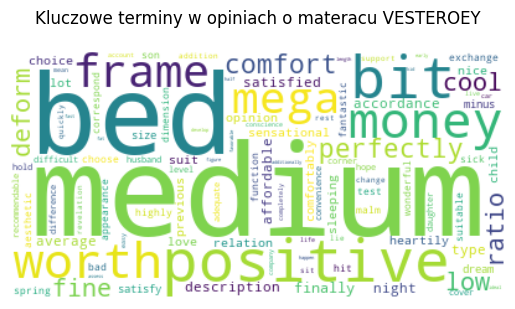

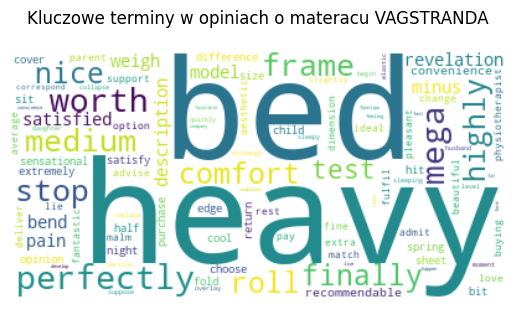

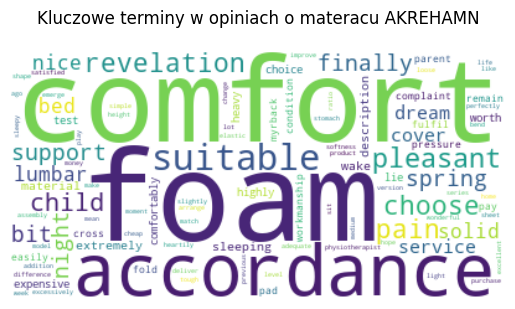

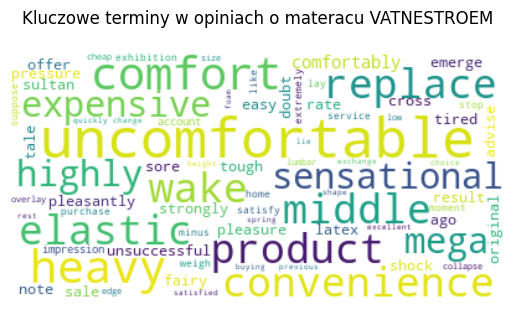

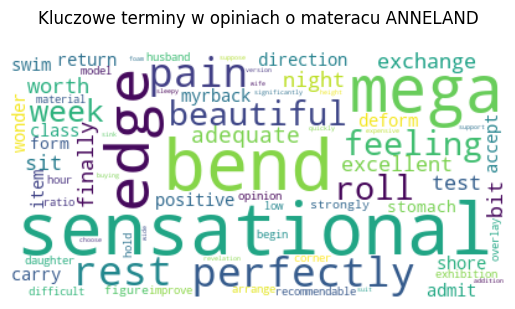

In [398]:
for name in list(df.name.unique()):
    generate_wordcloud(name)

___

### Wnioski

Analiza sentymentu opinii klientów o materacach IKEA ujawniła pozytywny odbiór produktów. Wszystkie badane modele miały dodatnie wartości wskaźnika sentymentu, choć z pewnym zróżnicowaniem.

Przeważały pozytywne opinie, świadczące o wysokiej satysfakcji klientów. Większość opinii była korzystna, z nielicznymi negatywnymi. Zmiany sentymentu w czasie pozostawały głównie w pozytywnym zakresie.

Klienci chwalili przede wszystkim komfort użytkowania, chętnie polecając produkty. Ważne były także oceny twardości, jakości snu oraz relacji ceny do jakości.